# Importa as bibliotecas de uso comum

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from google.colab import drive

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, StratifiedKFold
from os import listdir
from os.path import isfile, join

# Importa o Keras e os modelos pré-treinados

In [2]:
import keras

from keras.layers import Dense
from keras.layers import GlobalAveragePooling2D
from keras.layers import GlobalMaxPooling1D
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

from keras.models import Model
from keras.models import Sequential

from keras.applications.resnet50 import ResNet50 
from keras.applications.resnet50 import preprocess_input

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator


from keras.optimizers import Adam
from keras.optimizers import SGD

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau




In [3]:
keras.__version__

'2.5.0'

# Monta o Google Drive e define o diretorio das images

In [4]:
# Accessing My Google Drive
drive.mount('/content/drive',  force_remount=True)

#DATASET = 'drive/My Drive/UMLstudies/dataset_UML'
#CSV_DATASET = 'drive/My Drive/UMLstudies/dataset_UML.csv'
DATASET = 'drive/My Drive/UMLstudies/augmented_UML'
CSV_DATASET = 'drive/My Drive/UMLstudies/augmented_UML.csv'

SAVED_MODELS = 'drive/My Drive/UMLstudies/Models/ResNet/'

TEST_DIR = 'drive/My Drive/UMLstudies/dataset_UML_test'

Mounted at /content/drive


# Parametros variáveis para teste de treinamento

In [22]:
HEIGHT = 224
WIDTH = 224
COLOR_DEPTH = 3


BATCH_SIZE = 32
TESTE_NUM = 7
NUM_EPOCHS = 10
K_FOLD = 10


# Carrega o dataset
## A fazer
- Melhorar imagens para treino
- Verificar a  Validação
- Criar dataser de teste

In [23]:
#train_datagen=ImageDataGenerator(preprocessing_function = preprocess_input_resnet50) #included in our dependencies

idg=ImageDataGenerator(preprocessing_function = preprocess_input) #included in our dependencies


train_data = pd.read_csv(CSV_DATASET)
Y = train_data[['classes']]
n = Y.count()

print(n)
kf = KFold(n_splits = K_FOLD)
                         
skf = StratifiedKFold(n_splits = K_FOLD, random_state = 7, shuffle = True) 


classes    6000
dtype: int64


# Utilidades 

In [14]:

def load_model_weights(model, model_name):
  model_dir = os.path.join(SAVE_FINE_TUNING, model_name)
  checkpoint_path = os.path.join(model_dir, model_name)
  model.load_weights(checkpoint_path)

def save_model_weights(model, model_name):
  model_dir = os.path.join(SAVE_FINE_TUNING, model_name)
  checkpoint_path = os.path.join(model_dir, model_name)
  model.save_weights(checkpoint_path)

def freeze_model(model):
  for layer in model.layers:
    layer.trainable = False

def get_model_name(k):
    return '/model_ResNet_'+str(k)+'.h5'

 # Carrega o modelo ResNet50 para extração de caracteristicas

In [34]:
def create_new_model():

    #Instantiate a base model with pre-trained weigts. 
    #input_t = keras.Input(shape=(224, 224, 3))
    resnet = ResNet50(weights='imagenet',include_top=False, input_shape=(HEIGHT, WIDTH, COLOR_DEPTH)) 
    
    	# Unfreeze Layers
    for layer in resnet.layers[:143]:
        layer.trainable = False
    for layer in resnet.layers[143:]:
        layer.trainable = True

    output = resnet.layers[-1].output 
    output = keras.layers.Flatten()(output) 

    model = resnet.output
    model = GlobalAveragePooling2D()(model)

    predicao = Dense(6,activation='softmax')(model) 
    model=Model(inputs=resnet.input,outputs=predicao)


    return model

# explora o modelo

In [35]:
model = create_new_model()
print(model.summary())


# for i, layer in enumerate(model.layers):
#     print(i, layer.name)


ValueError: ignored

In [ ]:
trainable_params = 19463174
unfroozenLayer = 102

In [ ]:
pd.set_option('max_colwidth', -1) 
 
layers = [(layer, layer.name, layer.trainable) for layer in model.layers] 
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable']) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


Layer Type  ... Layer Trainable
0    <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7f47723f9048>               ...  False         
1    <tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7f47723f9390>          ...  False         
2    <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f47723f9470>                 ...  False         
3    <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f47723f99b0>  ...  False         
4    <tensorflow.python.keras.layers.core.Activation object at 0x7f47d7ace668>                      ...  False         
..                                                                         ...                      ...    ...         
172  <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f454be42160>  ...  True          
173  <tensorflow.python.keras.layers.merge.Add object at 0x7f454be42630>                            ...  True          
174  <tensorflow.python.keras.layers.core.Activation object at 0x7f454be425c0>                      ...  True          
175  <tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f454be23fd0>       ...  True          
176  <tensorflow.python.keras.layers.core.Dense object at 0x7f454be27208>                           ...  True          

[177 rows x 3 columns]

# Interacoes do K-FOLD

In [ ]:
VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

TRAIN_LOSS = []
TRAIN_ACCURACY = []

FOLD_VAR = 1

for train_index, val_index in skf.split(np.zeros(n),Y):
	print('\n-------\nK-FOLD ', FOLD_VAR)
	training_data = train_data.iloc[train_index]
	validation_data = train_data.iloc[val_index]
	
	train_data_generator = idg.flow_from_dataframe(training_data, directory = DATASET,
						       x_col = "id", y_col = "classes",
						       class_mode = "categorical", shuffle = True)
	valid_data_generator  = idg.flow_from_dataframe(validation_data, directory = DATASET,
							x_col = "id", y_col = "classes",
							class_mode = "categorical", shuffle = True)
	
	# CREATE CALLBACKS

  # This saves the best model
	checkpoint = ModelCheckpoint(SAVED_MODELS + get_model_name(FOLD_VAR), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')
 

	reduce_learning_rate = ReduceLROnPlateau(
		monitor="val_loss",
		factor=0.1,
		patience=3,
		verbose=1,
		mode="auto",
		min_delta=0.0001,
		cooldown=0,
		min_lr=1e-4
		)
 

	callbacks_list = [checkpoint, reduce_learning_rate]
	# There can be other callbacks, but just showing one because it involves the model name



	# CREATE NEW MODEL
	#model = create_new_model()
	model = create_new_model()

	# COMPILE NEW MODEL
	model.compile(loss='categorical_crossentropy',
		      optimizer='Adam',
		      metrics=['accuracy'])
	
	# FIT THE MODEL

	history = model.fit(train_data_generator,
			    epochs=NUM_EPOCHS,
			    callbacks=callbacks_list,
			    validation_data=valid_data_generator)
	#PLOT HISTORY


	# LOAD BEST MODEL to evaluate the performance of the model
	model.load_weights(SAVED_MODELS + "/model_ResNet_"+str(FOLD_VAR)+".h5")
	
	results = model.evaluate(valid_data_generator)
	results = dict(zip(model.metrics_names,results))
 
	TRAIN_ACCURACY.append(history.history['accuracy'][0])
	TRAIN_LOSS.append(history.history['loss'][0])
	
	VALIDATION_ACCURACY.append(results['accuracy'])
	VALIDATION_LOSS.append(results['loss'])
 

	print('K-FOLD {} - {}: {}'.format(FOLD_VAR, model.metrics_names[1], results['accuracy']))
	print('K-FOLD {} - {}: {}'.format(FOLD_VAR, model.metrics_names[0], results['loss']))
	
	keras.backend.clear_session()

	FOLD_VAR += 1



-------
K-FOLD  1
Found 5400 validated image filenames belonging to 6 classes.
Found 600 validated image filenames belonging to 6 classes.


ValueError: ignored

In [ ]:
# == Provide average scores ==
print('ResNet50 - unfreeze from layer {} - Trainable params: {} - epoch: {}'.format(unfroozenLayer, trainable_params, NUM_EPOCHS))
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, 10):
  print('------------------------------------------------------------------------')
  print('> Fold {} - Loss: {:.2f} - Accuracy: {:.2f}'.format(i+1, VALIDATION_LOSS[i], VALIDATION_ACCURACY[i]))
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print('> Accuracy: {:.2f}'.format(np.mean(VALIDATION_ACCURACY)))
print('> Loss: {:.2f}'.format(np.mean(VALIDATION_LOSS)))
print('------------------------------------------------------------------------')

ResNet50 - unfreeze from layer 102 - Trainable params: 19463174 - epoch: 10
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.09 - Accuracy: 0.98
------------------------------------------------------------------------
> Fold 2 - Loss: 0.07 - Accuracy: 0.97
------------------------------------------------------------------------
> Fold 3 - Loss: 0.10 - Accuracy: 0.98
------------------------------------------------------------------------
> Fold 4 - Loss: 0.08 - Accuracy: 0.98
------------------------------------------------------------------------
> Fold 5 - Loss: 0.05 - Accuracy: 0.98
------------------------------------------------------------------------
> Fold 6 - Loss: 0.06 - Accuracy: 0.98
------------------------------------------------------------------------
> Fold 7 - Loss: 0.03 - Accuracy: 0.99
----------------------------------------------------

In [ ]:
print(model.summary())

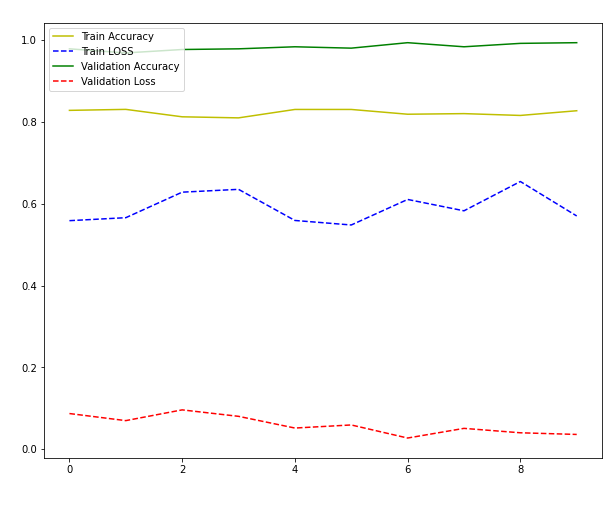

In [ ]:
# summarize history for accuracy

# summarize history for loss
plt.rcParams["figure.figsize"] = (10,8)
plt.plot(TRAIN_ACCURACY, '-y', label='Train Accuracy')
plt.plot(TRAIN_LOSS, '--b', label='Train LOSS')
plt.plot(VALIDATION_ACCURACY, '-g', label='Validation Accuracy')
plt.plot(VALIDATION_LOSS, '--r', label='Validation Loss')
plt.title('Loss and Accuracy', color='#fff')
plt.ylabel('Valores', color='#fff')
plt.xlabel('K-FOLD', fontsize=20, color='#fff')
plt.legend(loc='upper left')
plt.show()

# Testando o modelo

In [ ]:
classificacoes = ['Activity Diagram', 'Class Diagram', 'Component Diagram',
                  'Deployment Diagram', 'Sequence Diagram', 'Use Case Diagram'] 



In [ ]:
#test_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(299, 299),
        color_mode="rgb",
        shuffle = True,
        class_mode='categorical',
        batch_size=1)


Found 300 images belonging to 6 classes.


Instructions for updating:
Please use Model.predict, which supports generators.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


300/300 [==============================] - 73s 242ms/step
Confusion Matrix
[[11  8 12  7  6  6]
 [ 6  4 18 11  5  6]
 [ 7 11  8  4 10 10]
 [13  8  8  6 10  5]
 [ 7  7 14  3 12  7]
 [ 7  6  5 15  7 10]]


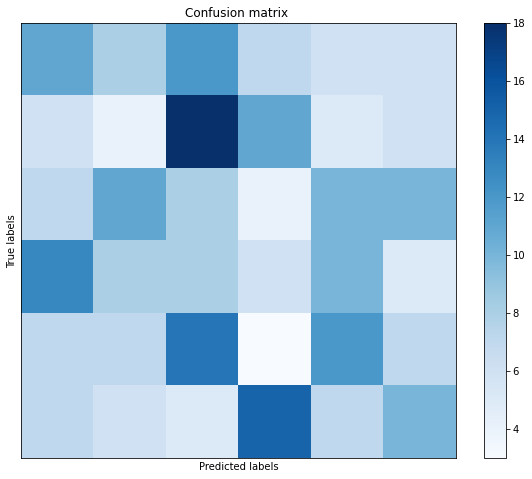

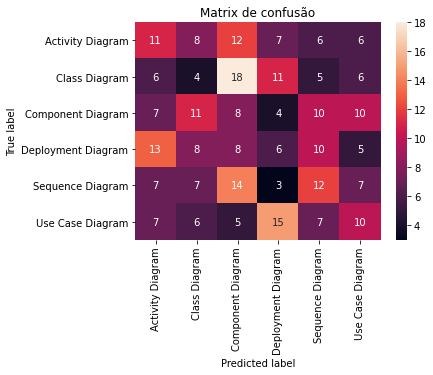

Classification Report
                    precision    recall  f1-score   support

  Activity_diagram       0.22      0.22      0.22        50
     Class_diagram       0.09      0.08      0.09        50
 Component_diagram       0.12      0.16      0.14        50
Deployment_diagram       0.13      0.12      0.12        50
  Sequence_diagram       0.24      0.24      0.24        50
  Use_case_diagram       0.23      0.20      0.21        50

          accuracy                           0.17       300
         macro avg       0.17      0.17      0.17       300
      weighted avg       0.17      0.17      0.17       300



In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
from sklearn import metrics


classificacoes = ['Activity Diagram', 'Class Diagram', 'Component Diagram',
                  'Deployment Diagram', 'Sequence Diagram', 'Use Case Diagram']

STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred= model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)


y_pred = np.argmax(pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))

cm = confusion_matrix(test_generator.classes, y_pred)

plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.xticks([], [])
plt.yticks([], [])
plt.title('Confusion matrix ')
plt.colorbar()
plt.show()

cm = confusion_matrix(test_generator.classes, y_pred) 

# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = ['Activity Diagram', 'Class Diagram', 'Component Diagram',
                  'Deployment Diagram', 'Sequence Diagram', 'Use Case Diagram'], 
                     columns = ['Activity Diagram', 'Class Diagram', 'Component Diagram',
                  'Deployment Diagram', 'Sequence Diagram', 'Use Case Diagram'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Matrix de confusão')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print('Classification Report')
report = metrics.classification_report(true_classes, y_pred, target_names=class_labels)
print(report)  


300/300 [==============================] - 4s 13ms/step


0.508

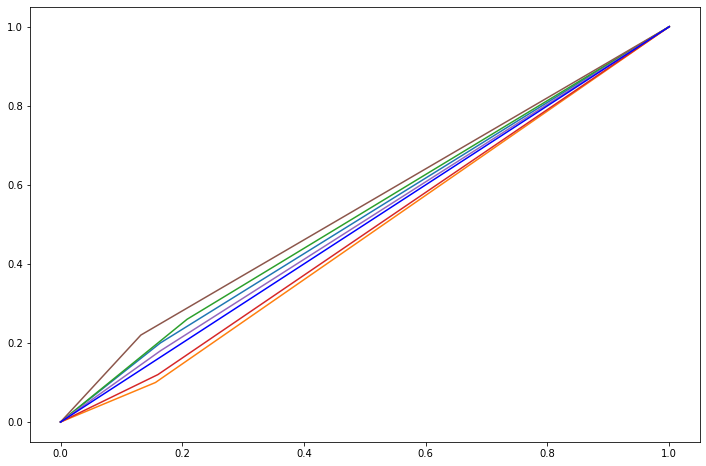

In [ ]:
from sklearn import preprocessing
from sklearn import metrics

classificacoes = ['Activity Diagram', 'Class Diagram', 'Component Diagram',
                  'Deployment Diagram', 'Sequence Diagram', 'Use Case Diagram']

fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(classificacoes): 
        fpr, tpr, thresholds = metrics.roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, metrics.auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return metrics.roc_auc_score(y_test, y_pred, average=average)

# calling
test_generator.reset() # resetting generator
y_pred = model.predict_generator(test_generator, verbose = True)
y_pred = np.argmax(y_pred, axis=1)
multiclass_roc_auc_score(test_generator.classes, y_pred)



In [ ]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

In [ ]:
from sklearn.metrics import confusion_matrix
predicted_class_indices=np.argmax(pred,axis=1)
labels=(test_generator.class_indices)
labels2=dict((v,k) for k,v in labels.items())
predictions=[labels2[k] for k in predicted_class_indices]
print(predicted_class_indices)
print(labels)
print(predictions)
confusion_matrix(predicted_class_indices, labels)



In [ ]:
#test_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

test_generator = test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=(299, 299),
        color_mode="rgb",
        shuffle = True,
        class_mode='categorical',
        batch_size=1)

In [ ]:
from keras.models import load_model
from skimage import transform
controle = 0
test_generator.reset()
model = load_model(SAVED_MODELS + 'model_ResNet_9.h5')


classificacoes = ['Activity Diagram', 'Class Diagram', 'Component Diagram',
                  'Deployment Diagram', 'Sequence Diagram', 'Use Case Diagram']

dirname = os.path.join(TEST_DIR, 'Activity_diagram')

if os.path.isdir(dirname):
    print("O diretório existe!")
else:
    print("O diretório não existe!")

files = [f for f in listdir(dirname) if isfile(join(dirname, f))]
files.sort()


def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (224, 224, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

controle = 0
for file in files:

  image_path = os.path.join(dirname, file)
  imagem = load(image_path)
  predictions = model.predict(imagem)

  print(predictions)
  classes = np.argmax(predictions)

  print(file, classificacoes[classes])

  if classificacoes[classes] == 'Activity Diagram':
    controle = controle + 1

porcento = (controle * 100)/50
print(predictions)
print('Activity Diagram')
print('Acertos: ', controle)
print('porcentage: ' + str(porcento) + '%')




In [ ]:
from keras.models import load_model
from skimage import transform
controle = 0
test_generator.reset()
model = load_model(SAVED_MODELS + 'model_ResNet_9.h5')


classificacoes = ['Activity Diagram', 'Class Diagram', 'Component Diagram',
                  'Deployment Diagram', 'Sequence Diagram', 'Use Case Diagram']

dirname = os.path.join(TEST_DIR, 'Class_diagram')

if os.path.isdir(dirname):
    print("O diretório existe!")
else:
    print("O diretório não existe!")

files = [f for f in listdir(dirname) if isfile(join(dirname, f))]
files.sort()


def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (224, 224, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

controle = 0
for file in files:

  image_path = os.path.join(dirname, file)
  imagem = load(image_path)
  predictions = model.predict(imagem)

  print(predictions)
  classes = np.argmax(predictions)

  print(file, classificacoes[classes])

  if classificacoes[classes] == 'Class Diagram':
    controle = controle + 1

porcento = (controle * 100)/50
print(predictions)
print('Class Diagram')
print('Acertos: ', controle)
print('porcentage: ' + str(porcento) + '%')




In [ ]:
from keras.models import load_model
from skimage import transform
controle = 0
test_generator.reset()
model = load_model(SAVED_MODELS + 'model_ResNet_9.h5')


classificacoes = ['Activity Diagram', 'Class Diagram', 'Component Diagram',
                  'Deployment Diagram', 'Sequence Diagram', 'Use Case Diagram']

dirname = os.path.join(TEST_DIR, 'Component_diagram')

if os.path.isdir(dirname):
    print("O diretório existe!")
else:
    print("O diretório não existe!")

files = [f for f in listdir(dirname) if isfile(join(dirname, f))]
files.sort()


def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (224, 224, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

controle = 0
for file in files:

  image_path = os.path.join(dirname, file)
  imagem = load(image_path)
  predictions = model.predict(imagem)

  print(predictions)
  classes = np.argmax(predictions)

  print(file, classificacoes[classes])

  if classificacoes[classes] == 'Component Diagram':
    controle = controle + 1

porcento = (controle * 100)/50
print(predictions)
print('Component Diagram')
print('Acertos: ', controle)
print('porcentage: ' + str(porcento) + '%')




In [ ]:
from keras.models import load_model
from skimage import transform
controle = 0
test_generator.reset()
model = load_model(SAVED_MODELS + 'model_ResNet_9.h5')


classificacoes = ['Activity Diagram', 'Class Diagram', 'Component Diagram',
                  'Deployment Diagram', 'Sequence Diagram', 'Use Case Diagram']

dirname = os.path.join(TEST_DIR, 'Deployment_diagram')

if os.path.isdir(dirname):
    print("O diretório existe!")
else:
    print("O diretório não existe!")

files = [f for f in listdir(dirname) if isfile(join(dirname, f))]
files.sort()


def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (224, 224, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

controle = 0
for file in files:

  image_path = os.path.join(dirname, file)
  imagem = load(image_path)
  predictions = model.predict(imagem)

  print(predictions)
  classes = np.argmax(predictions)

  print(file, classificacoes[classes])

  if classificacoes[classes] == 'Deployment Diagram':
    controle = controle + 1

porcento = (controle * 100)/50
print(predictions)
print('Deployment Diagram')
print('Acertos: ', controle)
print('porcentage: ' + str(porcento) + '%')




In [ ]:
from keras.models import load_model
from skimage import transform
controle = 0
test_generator.reset()
model = load_model(SAVED_MODELS + 'model_ResNet_9.h5')


classificacoes = ['Activity Diagram', 'Class Diagram', 'Component Diagram',
                  'Deployment Diagram', 'Sequence Diagram', 'Use Case Diagram']

dirname = os.path.join(TEST_DIR, 'Sequence_diagram')

if os.path.isdir(dirname):
    print("O diretório existe!")
else:
    print("O diretório não existe!")

files = [f for f in listdir(dirname) if isfile(join(dirname, f))]
files.sort()


def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (224, 224, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

controle = 0
for file in files:

  image_path = os.path.join(dirname, file)
  imagem = load(image_path)
  predictions = model.predict(imagem)

  print(predictions)
  classes = np.argmax(predictions)

  print(file, classificacoes[classes])

  if classificacoes[classes] == 'Sequence Diagram':
    controle = controle + 1

porcento = (controle * 100)/50
print(predictions)
print('Sequence Diagram')
print('Acertos: ', controle)
print('porcentage: ' + str(porcento) + '%')

In [ ]:
from keras.models import load_model
from skimage import transform
controle = 0
test_generator.reset()
model = load_model(SAVED_MODELS + 'model_ResNet_9.h5')


classificacoes = ['Activity Diagram', 'Class Diagram', 'Component Diagram',
                  'Deployment Diagram', 'Sequence Diagram', 'Use Case Diagram']

dirname = os.path.join(TEST_DIR, 'Use_case_diagram')

if os.path.isdir(dirname):
    print("O diretório existe!")
else:
    print("O diretório não existe!")

files = [f for f in listdir(dirname) if isfile(join(dirname, f))]
files.sort()


def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (224, 224, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

controle = 0
for file in files:

  image_path = os.path.join(dirname, file)
  imagem = load(image_path)
  predictions = model.predict(imagem)

  print(predictions)
  classes = np.argmax(predictions)

  print(file, classificacoes[classes])

  if classificacoes[classes] == 'Use Case Diagram':
    controle = controle + 1

porcento = (controle * 100)/50
print(predictions)
print('Use Case Diagram')
print('Acertos: ', controle)
print('porcentage: ' + str(porcento) + '%')